In [1]:
import torch
import requests
from PIL import Image
from io import BytesIO
from matplotlib import pyplot as plt

# We'll be exploring a number of pipelines today!
from diffusers import (
    StableDiffusionPipeline, 
    StableDiffusionImg2ImgPipeline,
    StableDiffusionInpaintPipeline, 
    StableDiffusionDepth2ImgPipeline
    )       

# We'll use a couple of demo images later in the notebook
def load(url):
    return Image.open(url).convert("RGB")

# Download images for inpainting example
img_url = "imgs/init.png"
mask_url = "imgs/mask.png"
init_image = load(img_url).resize((512, 512))
mask_image = load(mask_url).resize((512, 512))

/root/miniconda3/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = (
    "mps"
    if torch.backends.mps.is_available()
    else "cuda"
    if torch.cuda.is_available()
    else "cpu"
)

In [3]:
model_id = r"/opt/data/private/diffusion/stable-diffusion-2-1"
pipe = StableDiffusionPipeline.from_pretrained(model_id).to(device)

Loading pipeline components...: 100%|██████████| 6/6 [00:13<00:00,  2.23s/it]


100%|██████████| 50/50 [00:06<00:00,  8.33it/s]


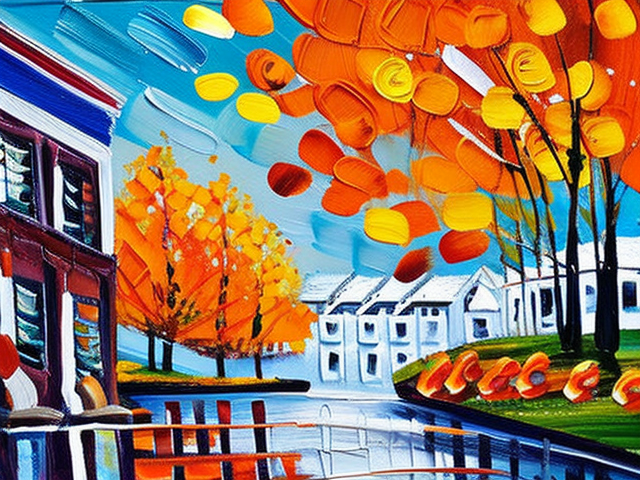

In [4]:
# Set up a generator for reproducibility
generator = torch.Generator(device=device).manual_seed(100)
print(generator)

# Run the pipeline, showing some of the available arguments
pipe_output = pipe(
    prompt="Palette knife painting of an autumn cityscape", # What to generate
    negative_prompt="Oversaturated, blurry, low quality", # What NOT to generate
    height=480, 
    width=640,     # Specify the image size
    guidance_scale=8,          # How strongly to follow the prompt
    num_inference_steps=50,    # How many steps to take
    generator=generator        # Fixed random seed
)

# View the resulting image:
pipe_output.images[0]

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:09<00:00, 10.90it/s]


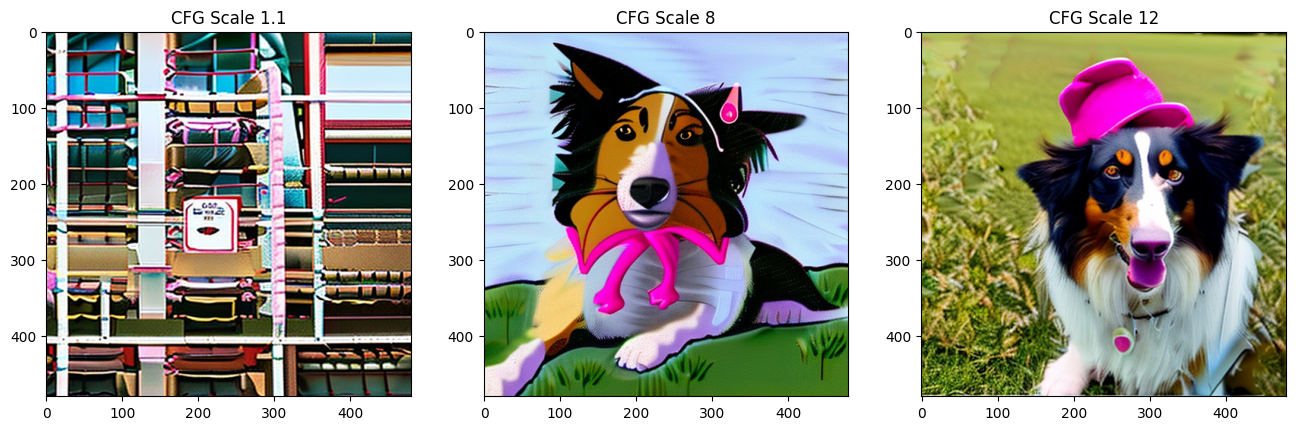

In [5]:
cfg_scales = [1.1, 8, 12] #@param
prompt = "A collie with a pink hat" #@param
seed = torch.Generator(device=device).manual_seed(42)
fig, axs = plt.subplots(1, len(cfg_scales), figsize=(16, 5))
for i, ax in enumerate(axs):
  im = pipe(prompt, 
            height=480, 
            width=480,
            guidance_scale=cfg_scales[i], 
            num_inference_steps=100,
            generator=seed).images[0]
  ax.imshow(im); ax.set_title(f'CFG Scale {cfg_scales[i]}')

In [6]:
# List components
print(list(pipe.components.keys()))

['vae', 'text_encoder', 'tokenizer', 'unet', 'scheduler', 'safety_checker', 'feature_extractor', 'image_encoder']


In [7]:
images = torch.rand(1, 3, 512, 512).to(device) * 2 - 1 
print("Input images shape:", images.shape)

# Encode to latent space
with torch.no_grad():
  latents = 0.18215 * pipe.vae.encode(images).latent_dist.mean
print("Encoded latents shape:", latents.shape)

# Decode again
with torch.no_grad():
  decoded_images = pipe.vae.decode(latents / 0.18215).sample
print("Decoded images shape:", decoded_images.shape)

Input images shape: torch.Size([1, 3, 512, 512])
Encoded latents shape: torch.Size([1, 4, 64, 64])
Decoded images shape: torch.Size([1, 3, 512, 512])


In [8]:
input_ids = pipe.tokenizer(["A painting of a flooble"])['input_ids']
print("Input ID -> decoded token")
for input_id in input_ids[0]:
  print(f"{input_id} -> {pipe.tokenizer.decode(input_id)}")

# Feed through CLIP text encoder
input_ids = torch.tensor(input_ids).to(device)
print(input_ids)
with torch.no_grad():
  text_embeddings = pipe.text_encoder(input_ids)['last_hidden_state']
print("Text embeddings shape:", text_embeddings.shape)

Input ID -> decoded token
49406 -> <|startoftext|>
320 -> a
3086 -> painting
539 -> of
320 -> a
4062 -> floo
1059 -> ble
49407 -> <|endoftext|>
tensor([[49406,   320,  3086,   539,   320,  4062,  1059, 49407]],
       device='cuda:0')
Text embeddings shape: torch.Size([1, 8, 1024])


In [9]:
# Get the final text embeddings using the pipeline's _encode_prompt function:
text_embeddings = pipe._encode_prompt("A painting of a flooble", device, 1, True, 'red')
text_embeddings.shape

/root/miniconda3/lib/python3.9/site-packages/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion.py:268: FutureWarning: `_encode_prompt()` is deprecated and it will be removed in a future version. Use `encode_prompt()` instead. Also, be aware that the output format changed from a concatenated tensor to a tuple.
  deprecate("_encode_prompt()", "1.0.0", deprecation_message, standard_warn=False)


torch.Size([2, 77, 1024])

In [10]:
timestep = pipe.scheduler.timesteps[0]
latents = torch.randn(1, 4, 64, 64).to(device)
text_embeddings = torch.randn(1, 77, 1024).to(device)

# Model prediction:
with torch.no_grad():
  unet_output = pipe.unet(latents, timestep, text_embeddings).sample
print('UNet output shape:', unet_output.shape) # Same shape as the input latents

UNet output shape: torch.Size([1, 4, 64, 64])


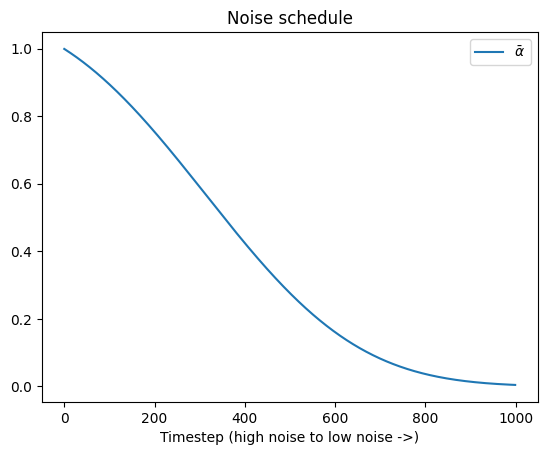

In [11]:
plt.plot(pipe.scheduler.alphas_cumprod, label=r'$\bar{\alpha}$')
plt.xlabel('Timestep (high noise to low noise ->)')
plt.title('Noise schedule');plt.legend()

/root/miniconda3/lib/python3.9/site-packages/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion.py:559: FutureWarning: The decode_latents method is deprecated and will be removed in 1.0.0. Please use VaeImageProcessor.postprocess(...) instead
  deprecate("decode_latents", "1.0.0", deprecation_message, standard_warn=False)


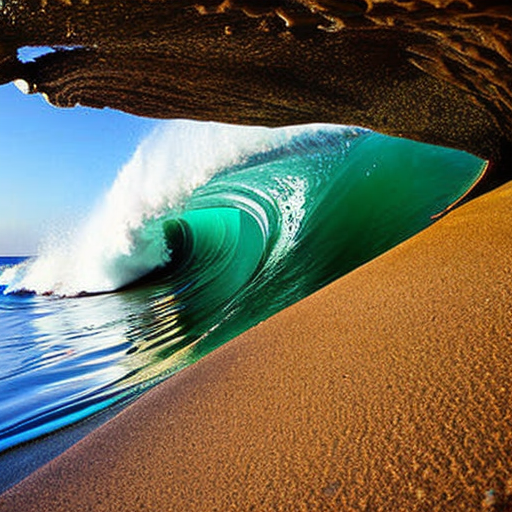

In [12]:
guidance_scale = 8 
num_inference_steps=100
prompt = "Beautiful picture of a wave breaking" 
negative_prompt = "zoomed in, blurry, oversaturated, warped" 

# Encode the prompt
text_embeddings = pipe._encode_prompt(prompt, device, 1, True, negative_prompt)

# Create our random starting point
latents = torch.randn((1, 4, 64, 64), device=device, generator=generator)
latents *= pipe.scheduler.init_noise_sigma

# Prepare the scheduler
pipe.scheduler.set_timesteps(num_inference_steps, device=device)

# Loop through the sampling timesteps
for i, t in enumerate(pipe.scheduler.timesteps):

  # expand the latents if we are doing classifier free guidance
  latent_model_input = torch.cat([latents] * 2)

  # Apply any scaling required by the scheduler
  latent_model_input = pipe.scheduler.scale_model_input(latent_model_input, t)

  # predict the noise residual with the unet
  with torch.no_grad():
    noise_pred = pipe.unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

  # perform guidance
  noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
  noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

  # compute the previous noisy sample x_t -> x_t-1
  latents = pipe.scheduler.step(noise_pred, t, latents).prev_sample

# Decode the resulting latents into an image
with torch.no_grad():
  image = pipe.decode_latents(latents.detach())

# View
pipe.numpy_to_pil(image)[0]

In [13]:
# Loading an Img2Img pipeline
model_id = "/opt/data/private/diffusion/stable-diffusion-2-1"
img2img_pipe = StableDiffusionImg2ImgPipeline.from_pretrained(model_id).to(device)

Loading pipeline components...: 100%|██████████| 6/6 [00:03<00:00,  1.61it/s]


100%|██████████| 30/30 [00:02<00:00, 10.11it/s]


Text(0.5, 1.0, 'Result')

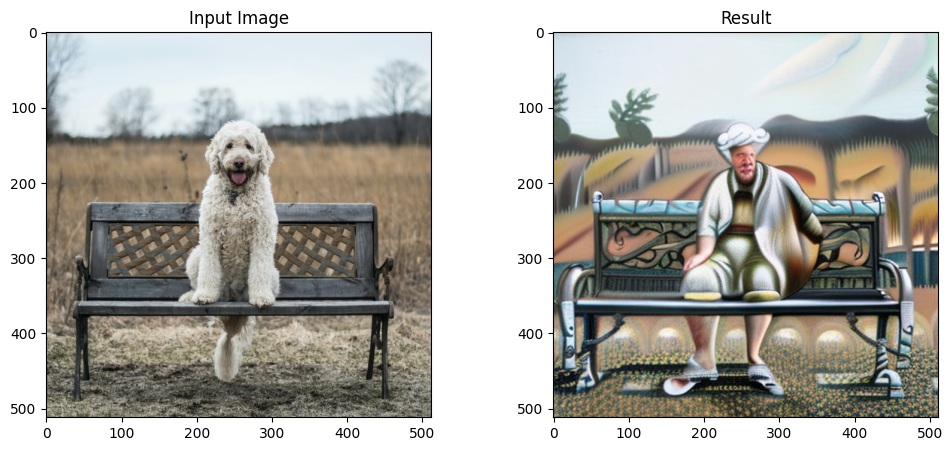

In [14]:
result_image = img2img_pipe(
    prompt="An oil painting of a man on a bench",
    image = init_image, # The starting image
    strength = 0.6, # 0 for no change, 1.0 for max strength
).images[0]

fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].imshow(init_image);axs[0].set_title('Input Image')
axs[1].imshow(result_image);axs[1].set_title('Result')